# Data import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

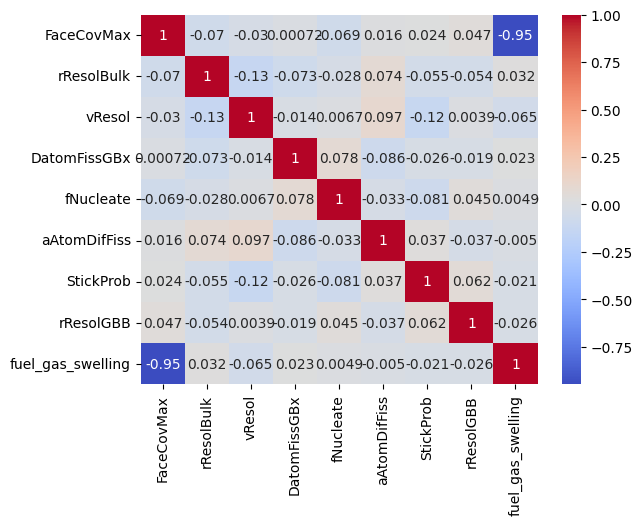

In [2]:
jar = pd.read_csv('data.csv')
jar.drop('fuel_swelling', axis=1, inplace=True)
jar = jar[jar['fuel_gas_swelling'] <= 100]
sns.heatmap(jar.corr(), annot=True, cmap='coolwarm')

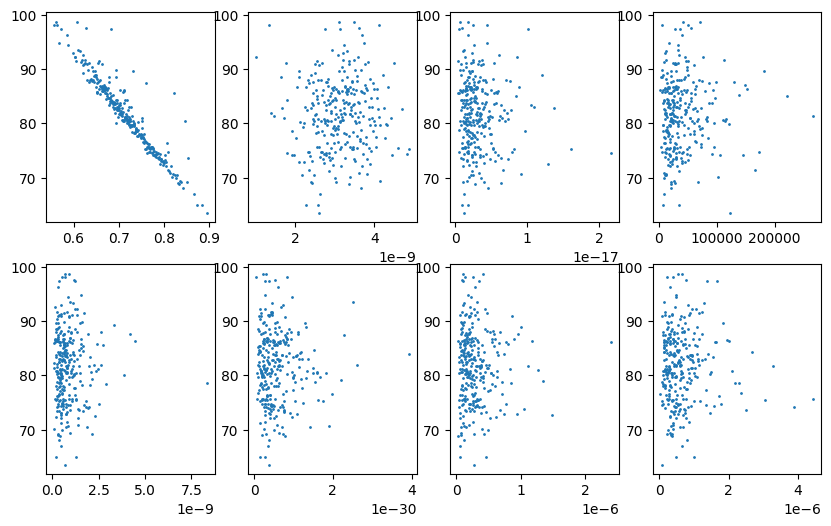

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.scatter(jar.iloc[:,i], jar.iloc[:,8], s=1)
    
plt.show()

# Preprocessing

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
feat_ind = list(range(8))
features = jar.iloc[:, feat_ind]
features

,FaceCovMax,rResolBulk,vResol,DatomFissGBx,fNucleate,aAtomDifFiss,StickProb,rResolGBB
0,0.650872,3.281529e-09,5.696813e-18,9720.560229,2.415274e-09,5.458748e-31,1.250136e-07,6.908243e-07
1,0.700489,3.405615e-09,2.270948e-18,10617.119460,3.584054e-10,5.298310e-31,1.674882e-07,9.826777e-07
2,0.770661,3.548509e-09,1.371849e-18,25422.010780,1.667374e-10,3.316310e-31,3.433259e-07,3.038373e-06
4,0.704481,2.530986e-09,3.591396e-18,19902.464330,8.047679e-10,2.323996e-31,3.178563e-07,4.354383e-07
5,0.866433,2.614630e-09,1.295106e-18,9409.333710,4.883834e-10,3.546486e-31,5.975684e-08,6.426013e-07
...,...,...,...,...,...,...,...,...
391,0.764632,2.558002e-09,1.349131e-18,4273.639687,1.258036e-09,2.874737e-31,1.197161e-07,6.933030e-07
394,0.662000,3.351414e-09,7.784369e-19,29771.793960,8.707109e-10,3.772896e-31,1.974038e-07,2.815382e-07
395,0.722900,2.798555e-09,2.656561e-18,19130.359460,1.053442e-09,1.895258e-31,1.830481e-07,6.757461e-07
397,0.620248,3.066550e-09,6.118671e-18,35262.843210,1.243444e-10,6.898974e-31,2.140948e-07,4.455297e-07


In [6]:
xscaler = StandardScaler()
X = xscaler.fit_transform(features)
X

array([[-1.02009387,  0.26353043,  0.95373073, ..., -0.07369275,
        -0.6556652 ,  0.057345  ],
       [-0.23574651,  0.45461517, -0.37508948, ..., -0.1070851 ,
        -0.49789708,  0.55462435],
       [ 0.87351965,  0.67466474, -0.72383119, ..., -0.5196033 ,
         0.15523643,  4.05725459],
       ...,
       [ 0.11852919, -0.48021921, -0.22551851, ..., -0.81537011,
        -0.44010117,  0.03165373],
       [-1.50419018, -0.06752411,  1.11736081, ...,  0.22606476,
        -0.32478124, -0.3606043 ],
       [ 1.06322318,  2.64906415, -0.17981412, ..., -0.34318859,
         0.09285531,  1.58980859]])

In [7]:
y = jar['fuel_gas_swelling']
y

0      85.720906
1      82.491144
2      75.449293
4      81.658898
5      66.987642
         ...    
391    75.588533
394    91.055492
395    79.649376
397    92.631420
398    74.451455
Name: fuel_gas_swelling, Length: 290, dtype: float64

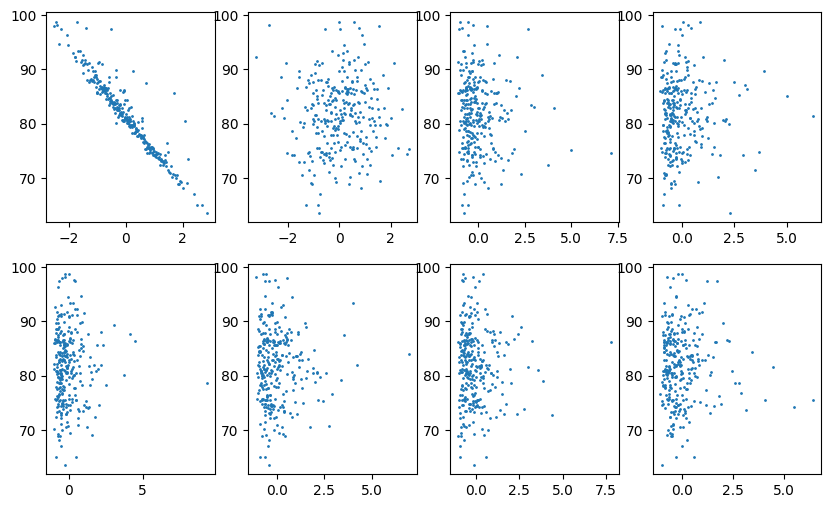

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.scatter(X[:,i], y, s=1)
    
plt.show()

# NN

In [9]:
from sklearn.neural_network import MLPRegressor

In [10]:
nnreg = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', random_state=42, max_iter=2000)
nnreg.fit(X, y)

MLPRegressor(activation='logistic', max_iter=2000, random_state=42)

In [11]:
rng = np.random.RandomState(42)
X_test = rng.randn(290, 8)

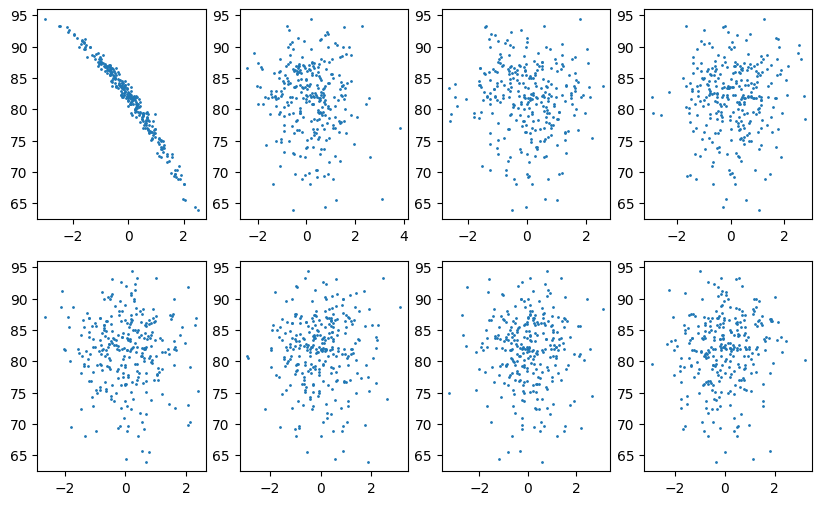

In [12]:
y_pred = nnreg.predict(X_test)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(X_test[:,i], y_pred, s=1)
    
plt.show()

# MCMC

In [13]:
import arviz as az
import pymc as pm

In [14]:
az.style.use("arviz-darkgrid")

In [17]:
with pm.Model() as gpmod:
    ell = pm.Normal("ell", mu=0, sigma=10)
    cov = pm.gp.cov.Linear(8, ell) + pm.gp.cov.WhiteNoise(ell)
    
    gp = pm.gp.Marginal(cov_func=cov)

    sigma = pm.HalfNormal("sigma", sigma=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y, sigma=sigma)

In [ ]:
with gpmod:
    marginal_post = pm.sample(20, chains=1)

In [ ]:
az.plot_trace(marginal_post, combined=True)

In [24]:
with gpmod:
    x2 = pm.Normal("x2", mu=0, sigma=10, shape=8)

    pred = gp.conditional("pred", x2, shape=8)

IndexError: too many indices for array